<a href="https://colab.research.google.com/github/SMN-SENAMHI/S2S/blob/main/APS_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart: NOAA GEFS forecast, 35 day - dynamical.org zarr
Este recurso ofrece una introducción rápida al conjunto de datos del modelo de pronóstico NOAA GEFS (Global Ensemble Forecast System) con horizonte de 35 días, el cual ha sido transformado por Dynamical.org a un formato listo para análisis y optimizado para la nube utilizando Zarr.

*El conjunto de datos incluye variables meteorológicas y climáticas clave, en una estructura que permite:

*Acceso rápido y eficiente desde plataformas en la nube.

*Procesamiento paralelo y en tiempo real para aplicaciones de ciencia de datos, inteligencia artificial o visualización.

*Exploración del pronóstico extendido (S2S: subseasonal to seasonal) con múltiples miembros del ensamble.

🔗 Documentación completa del conjunto de datos:
https://dynamical.org/catalog/noaa-gefs-forecast-35-day/



In [ ]:
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp > /dev/null 2>&1
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install cython > /dev/null 2>&1
!pip install cartopy > /dev/null 2>&1
!pip install geopy > /dev/null 2>&1


In [ ]:
import xarray as xr
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ============================
# 1. Abrir dataset GEFS (Zarr)
# ============================
url = "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com"
ds = xr.open_zarr(url, decode_timedelta=True)

# ============================
# 2. Variables disponibles
# ============================
print("\n Variables disponibles en el dataset GEFS:")
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "")
    desc = ds[var].attrs.get("long_name", "")
    print(f" - {var}: {desc} [{units}]")

# ============================
# 3. Fechas de inicio de pronóstico
# ============================
if "init_time" in ds.coords:
    t0 = pd.to_datetime(ds.init_time.values[0])
    tf = pd.to_datetime(ds.init_time.values[-1])
    print("\n Rango temporal de 'init_time':")
    print("Inicio :", t0.strftime("%Y-%m-%d %H:%M:%S"))
    print("Fin    :", tf.strftime("%Y-%m-%d %H:%M:%S"))

# ============================
# 4. Información de ensembles
# ============================
if "ensemble_member" in ds.dims:
    n_ens = ds.dims["ensemble_member"]
    ens_vals = ds["ensemble_member"].values
    print(f"\n Número de miembros en el ensamble: {n_ens}")
    print("Listado de ensemble_member:")
    print(ens_vals)



 Variables disponibles en el dataset GEFS:
 - categorical_freezing_rain_surface: Categorical freezing rain [0=no; 1=yes]
 - categorical_ice_pellets_surface: Categorical ice pellets [0=no; 1=yes]
 - categorical_rain_surface: Categorical rain [0=no; 1=yes]
 - categorical_snow_surface: Categorical snow [0=no; 1=yes]
 - downward_long_wave_radiation_flux_surface: Surface downward long-wave radiation flux [W/(m^2)]
 - downward_short_wave_radiation_flux_surface: Surface downward short-wave radiation flux [W/(m^2)]
 - geopotential_height_cloud_ceiling: Geopotential height [gpm]
 - maximum_temperature_2m: Maximum temperature [C]
 - minimum_temperature_2m: Minimum temperature [C]
 - percent_frozen_precipitation_surface: Percent frozen precipitation [%]
 - precipitable_water_atmosphere: Precipitable water [kg/(m^2)]
 - precipitation_surface: Total Precipitation [mm/s]
 - pressure_reduced_to_mean_sea_level: Pressure reduced to MSL [Pa]
 - pressure_surface: Surface pressure [Pa]
 - relative_humidi

In [ ]:
#@title CONFIGURACIÓN Y SHAPEFILES
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import pandas as pd
import tempfile, requests, os, gc
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore")

# Fecha de inicio (manual o None para tomar la última disponible)
fecha_inicio_manual = "2025-06-30"

# Descargar shapefiles de Perú
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shx",
}
tempdir = tempfile.mkdtemp()
for filename, url in shapefiles.items():
    r = requests.get(url)
    with open(os.path.join(tempdir, filename), "wb") as f:
        f.write(r.content)
gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))
print("Shapefiles cargados correctamente")



Shapefiles cargados correctamente


In [ ]:
#@title ABRIR ZARR DE GEFS
# Abrir dataset GEFS con chunks para no saturar memoria
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr",
    chunks={"lead_time": 24, "latitude": 50, "longitude": 50},
    decode_timedelta=True
)

# Seleccionar init_time
init_times = pd.to_datetime(ds.init_time.values)
if fecha_inicio_manual:
    fecha_inicio_manual_dt = np.datetime64(fecha_inicio_manual)
    if fecha_inicio_manual_dt in ds.init_time.values:
        init_time_usado = fecha_inicio_manual_dt
    else:
        init_time_usado = init_times.max()
else:
    init_time_usado = init_times.max()

print("Usando init_time:", pd.to_datetime(init_time_usado).strftime("%Y-%m-%d"))

# Subset espacial y temporal
ds_sub = ds.sel(init_time=init_time_usado).sel(latitude=slice(10, -50), longitude=slice(-120, -50))
ds_members = ds_sub.sel(lead_time=slice("0h", "27d"))




Usando init_time: 2025-06-30


In [ ]:
#@title PROCESAMIENTO POR SEMANAS
# Variables principales
pressure_all = ds_members["pressure_reduced_to_mean_sea_level"] / 100
u10_all = ds_members["wind_u_10m"]
v10_all = ds_members["wind_v_10m"]

# Ajuste de tiempo
forecast_time = ds_members.init_time + ds_members.lead_time
for var in [pressure_all, u10_all, v10_all]:
    var.coords["forecast_time"] = forecast_time
    var = var.swap_dims({"lead_time": "forecast_time"})

# Promedios diarios (corregido, sin dim="forecast_time")
pressure_daily_all = pressure_all.groupby("forecast_time.date").mean()
u10_daily_all      = u10_all.groupby("forecast_time.date").mean()
v10_daily_all      = v10_all.groupby("forecast_time.date").mean()

# Promedio de ensamble
pressure_prom = pressure_daily_all.mean(dim="ensemble_member")
u10_prom      = u10_daily_all.mean(dim="ensemble_member")
v10_prom      = v10_daily_all.mean(dim="ensemble_member")

# Definir semanas
semanas = {
    "SEMANA 1": slice(0, 7),
    "SEMANA 2": slice(7, 14),
    "SEMANA 3": slice(14, 21),
    "SEMANA 4": slice(21, 28),
}
print("Procesamiento de semanas completado")



Procesamiento de semanas completado


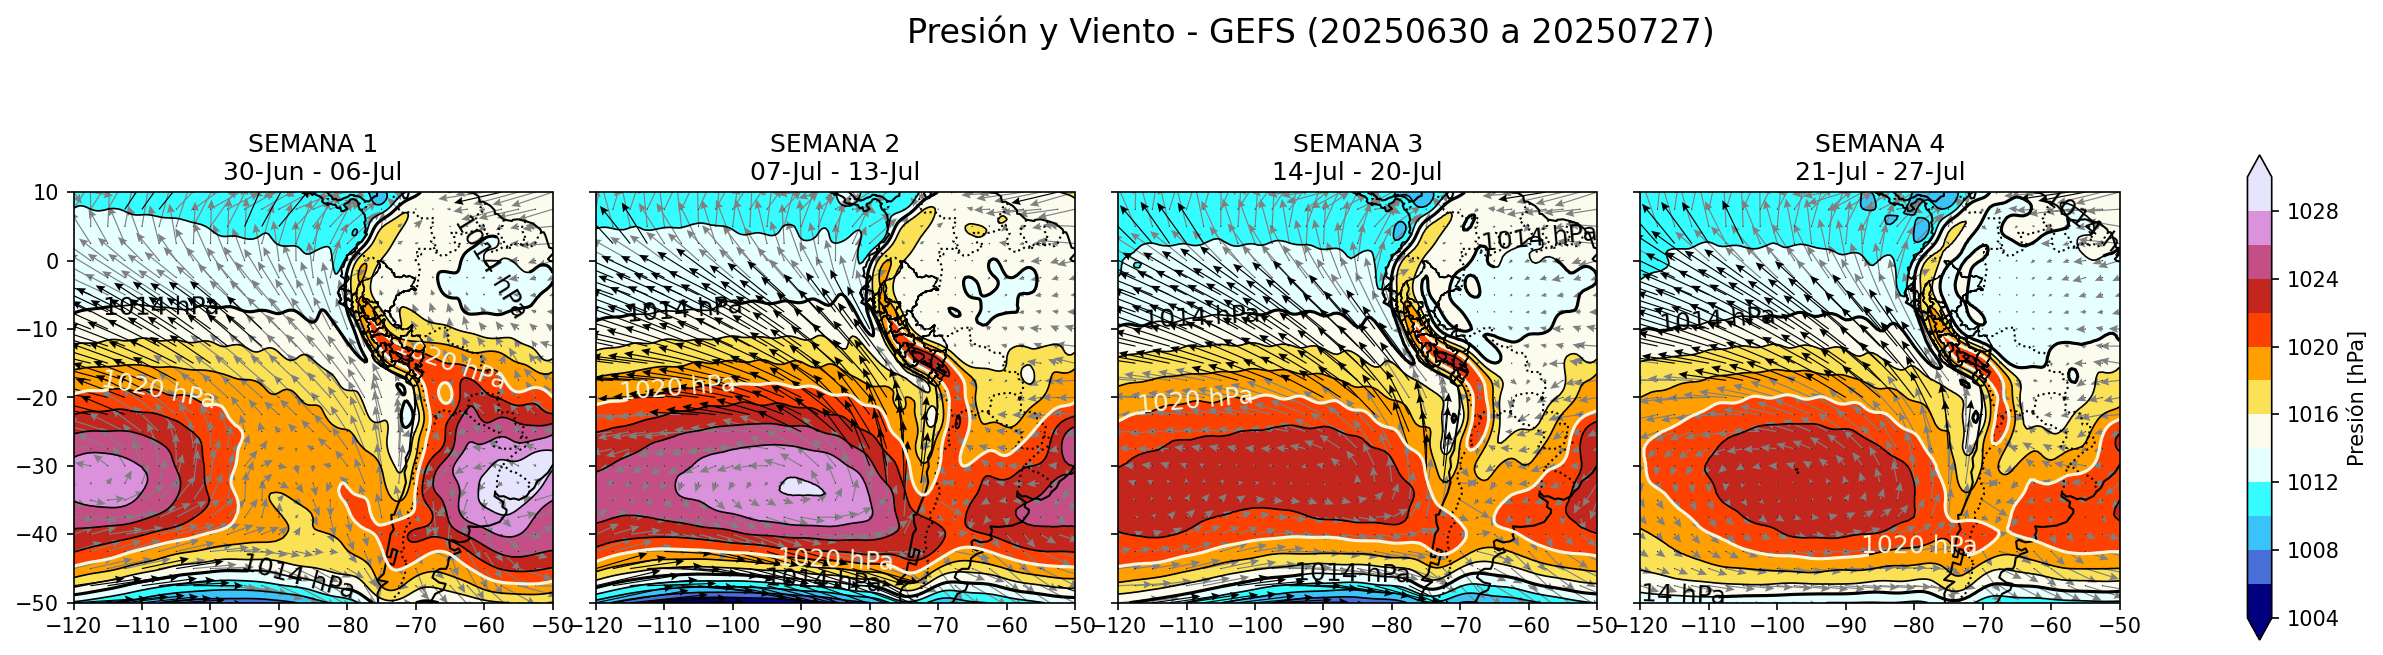

 Imagen guardada como: ASP_presion_viento_20250630_20250727_init20250630.png


NameError: name 'ds' is not defined

In [ ]:
#@title GRAFICAR Y EXPORTAR RESULTADO
fig, axes = plt.subplots(1, 4, figsize=(22, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
fig.subplots_adjust(wspace=0.09)

#extent = [-120, -50, -50, 10]
extent = [-120, -50, -50, 10]
x_ticks = range(-120, -49, 10)
y_ticks = range(-50, 11, 10)
colors = ["#01007E", "#486ED7", "#39C3F8", "#35FCFF", "#E6FFFF",
          "#FBFCEE", "#F6F6DE", "#FAE156", "#FFA000", "#FC4100",
          "#C3261D", "#C34F86", "#DA92DD", "#E7E5FD"]
cmap_custom = mcolors.ListedColormap(colors)
contour_levels = np.arange(1004, 1032, 2)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    pres_avg = pressure_prom.isel(date=rango).mean(dim="date").compute()
    u10_avg = u10_prom.isel(date=rango).mean(dim="date").compute()
    v10_avg = v10_prom.isel(date=rango).mean(dim="date").compute()

    lon, lat = np.meshgrid(pres_avg.longitude.values, pres_avg.latitude.values)
    mslp_values = pres_avg.values
    uwnd_values = u10_avg.values
    vwnd_values = v10_avg.values

    wind_magnitude = np.sqrt(uwnd_values**2 + vwnd_values**2)
    mask_black = wind_magnitude > 7
    mask_gray = ~mask_black

    #ax.set_extent(extent, crs=ccrs.PlateCarree())
    #ax.coastlines(); ax.add_feature(cfeature.BORDERS, linestyle=":")

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelbottom=True, labelleft=(i == 0))
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)

    cmap_mslp = ax.contourf(lon, lat, mslp_values, levels=contour_levels, cmap=cmap_custom, extend='both')
    ax.contour(lon, lat, mslp_values, levels=contour_levels, colors='black', linewidths=0.8)

    ax.clabel(ax.contour(lon, lat, mslp_values, levels=[1020], colors='#F6F6DC', linewidths=1.5),
              inline=True, fontsize=12, fmt='%d hPa', colors='#F6F6DC')
    ax.clabel(ax.contour(lon, lat, mslp_values, levels=[1014], colors='black', linewidths=1.5),
              inline=True, fontsize=12, fmt='%d hPa', colors='black')

    # Vectores de viento
    skip = (slice(None, None, 10), slice(None, None, 10))
    ax.quiver(lon[skip], lat[skip],
              uwnd_values[skip] * mask_gray[skip], vwnd_values[skip] * mask_gray[skip],
              color='#808080', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7)
    ax.quiver(lon[skip], lat[skip],
              uwnd_values[skip] * mask_black[skip], vwnd_values[skip] * mask_black[skip],
              color='black', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7)

    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, zorder=10)

    week_dates = pressure_prom.date.values[rango]
    ax.set_title(f"{semana}\n{pd.to_datetime(str(week_dates[0])).strftime('%d-%b')} - "
                 f"{pd.to_datetime(str(week_dates[-1])).strftime('%d-%b')}")

# Barra de color
cbar = fig.colorbar(cmap_mslp, ax=axes.ravel().tolist(),
                    orientation="vertical", shrink=0.7)
cbar.set_label("Presión [hPa]")

# Guardar salida
start_forecast = pd.to_datetime(str(pressure_prom.date.values[0])).strftime("%Y%m%d")
end_forecast = pd.to_datetime(str(pressure_prom.date.values[-1])).strftime("%Y%m%d")
output_file = f"ASP_presion_viento_{start_forecast}_{end_forecast}_init{pd.to_datetime(init_time_usado).strftime('%Y%m%d')}.png"

plt.suptitle(f"Presión y Viento - GEFS ({start_forecast} a {end_forecast})",
             fontsize=16, y=0.92)
plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1, dpi=150)
plt.show()

print(f" Imagen guardada como: {output_file}")


